In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
import modin.pandas as md
#import databricks.koalas as ks

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [7]:
outdirs = ["kv-de0d46e"]
num_shards = [2, 4, 6, 8]
ops = [1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000, 160000, 200000, 240000, 320000]
clients = ['10.1.1.5', '10.1.1.6', '10.1.1.7', '10.1.1.8', '10.1.1.9']
shard_types = ['client', 'server', 'basicclient']
client_concurrency = [4, 8]

In [8]:
#df = ks.read_csv(f"{outdirs[0]}/*.data", sep=" ")
#df = df[(df.NumOps > 200e3) & (df.NumShards > 1)]
df = None
for outdir in outdirs:
    for ns in num_shards:
        for o in ops:
            for st in shard_types:
                for cl in clients:
                    for c in client_concurrency:
                        fn = f"{outdir}/{ns}-{st}shard-{o}-wrkloadbunf1-{c}-0-client0-{cl}.data"
                        try:
                            df_file = md.read_csv(fn, sep=" ")
                            df_file = df_file[(df_file.NumOps > 200e3) & (df_file.NumShards > 1)]
                            df_file["Concurrency"] = c
                            df_file["Commit"] = outdir
                            if df is None:
                                df = df_file
                            else:
                                df = df.append(df_file)
                        except:
                            continue

dfq = df.groupby(["ShardType", "NumShards", "Wrkload", "Concurrency", "Ops"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95])
dfq.head()

Interarrival_us  \
ShardType   NumShards Wrkload                                            Concurrency Ops                           
basicclient 2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000 0.05           2000.0   
                                                                                           0.25           2000.0   
                                                                                           0.50           2000.0   
                                                                                           0.75           2000.0   
                                                                                           0.95           2000.0   

                                                                                                   NumOps  \
ShardType   NumShards Wrkload                                            Concurrency Ops                    
basicclient 2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000 0.05  275066.0   
                                                                                           0.25  275175.0   
                                                                                           0.50  276460.0   
                                                                                           0.75  276501.0   
                                                                                           0.95  276501.0   

                                                                                                 Completion_ms  \
ShardType   NumShards Wrkload                                            Concurrency Ops                         
basicclient 2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000 0.05       137610.0   
                                                                                           0.25       137903.0   
                                                                                           0.50       138516.0   
                                                                                           0.75       138575.0   
                                                                                           0.95       138575.0   

                                                                                                 Latency_us  
ShardType   NumShards Wrkload                                            Concurrency Ops                     
basicclient 2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000 0.05       119.0  
                                                                                           0.25       133.0  
                                                                                           0.50       141.0  
                                                                                           0.75       157.0  
                                                                                           0.95       402.0

In [9]:
dfqu = dfq.unstack()
dfqu.columns = [f"{s}_{t}" for s,t in dfqu.columns.values]
dfqu.columns.to_flat_index()
dfqu.to_csv('/tmp/kv-tmp.csv')
dfqu

Interarrival_us_0.05  \
ShardType   NumShards Wrkload                                            Concurrency Ops                           
basicclient 2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
            4         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
            6         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
server      2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
                                                                                     60000                 333.0   
            4         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
                                                                                     60000                 333.0   
            6         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
                                                                                     60000                 333.0   

                                                                                            Interarrival_us_0.25  \
ShardType   NumShards Wrkload                                            Concurrency Ops                           
basicclient 2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
            4         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
            6         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                                                                                     20000                1000.0   
                                                                                     40000                 500.0   
server      2         /home/akshayn/burrito/kvstore-ycsb/ycsbc-mock/w... 4           10000                2000.0   
                               

In [10]:
pdf = pd.read_csv('/tmp/kv-tmp.csv')

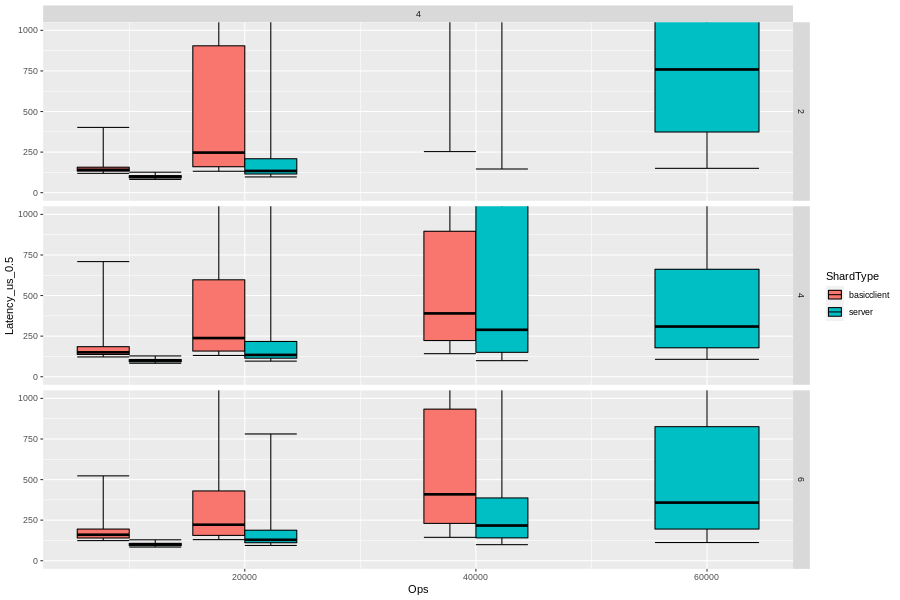

In [11]:
%%R -i pdf -w 900 -h 600

library(ggplot2)

#geom_boxplot(aes(group=interaction(ShardType,Ops)), position="dodge") + 
#ggplot(pdf, aes(x=Ops, y=Latency_us, 
#  fill=ShardType, group=interaction(ShardType,Ops))) + 
#    stat_summary(fun.data = f, geom="boxplot", position="dodge") + 
#    facet_grid(NumShards~Concurrency) +
#    coord_cartesian(ylim=c(0, 10000))

ggplot(pdf, aes(x=Ops, fill=ShardType, group=interaction(ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  facet_grid(NumShards~Concurrency) +
  coord_cartesian(ylim=c(0, 1000))
    

#### With a dedicated load balancer

In [2]:
lboutdirs = ["kvlb-1883ee8", "kvlb-79b6c33"]
# num_shards = 2 machines, fixed
lbops = [5000, 10000, 20000, 40000, 60000, 80000, 100000]
lbshard_types = ['client', 'server']
lbclients = ['10.1.1.7', '10.1.1.8', '10.1.1.9']
lbclient_concurrency = [4, 8]

In [3]:
lbdf = None
for lboutdir in lboutdirs:
    for o in lbops:
        for st in lbshard_types:
            for cl in lbclients:
                for c in lbclient_concurrency:
                    fn = f"{lboutdir}/{st}shard-{o}-wrkloadbunf1-{c}-client0-{cl}.data"
                    try:
                        df_file = md.read_csv(fn, sep=" ")
                        df_file = df_file[(df_file.NumOps > 200000)]
                        df_file["Commit"] = lboutdir
                        df_file["Concurrency"] = c
                        if lbdf is None:
                            lbdf = df_file
                        else:
                            lbdf = lbdf.append(df_file)
                    except:
                        continue

lbdfq = lbdf.groupby(["Commit", "ShardType", "NumShards", "Ops", "Concurrency"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95])
lbdfq

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

To request implementation, send an email to feature_requests@modin.org.


Interarrival_us  \
Commit       ShardType NumShards Ops    Concurrency                         
kvlb-1883ee8 client    2         10000  4           0.05           1200.0   
                                                    0.25           1200.0   
                                                    0.50           1200.0   
                                                    0.75           1200.0   
                                                    0.95           1200.0   
...                                                                   ...   
kvlb-79b6c33 server    2         100000 4           0.05            120.0   
                                                    0.25            120.0   
                                                    0.50            120.0   
                                                    0.75            120.0   
                                                    0.95            120.0   

                                                            NumOps  \
Commit       ShardType NumShards Ops    Concurrency                  
kvlb-1883ee8 client    2         10000  4           0.05  274507.0   
                                                    0.25  274507.0   
                                                    0.50  274746.0   
                                                    0.75  275228.0   
                                                    0.95  275228.0   
...                                                            ...   
kvlb-79b6c33 server    2         100000 4           0.05  275709.0   
                                                    0.25  275709.0   
                                                    0.50  276098.0   
                                                    0.75  276705.0   
                                                    0.95  276705.0   

                                                          Completion_ms  \
Commit       ShardType NumShards Ops    Concurrency                       
kvlb-1883ee8 client    2         10000  4           0.05        82449.0   
                                                    0.25        82449.0   
                                                    0.50        82584.0   
                                                    0.75        82842.0   
                                                    0.95        82842.0   
...                                                                 ...   
kvlb-79b6c33 server    2         100000 4           0.05         8324.0   
                                                    0.25         8324.0   
                                                    0.50         8393.0   
                                                    0.75         8395.0   
                                                    0.95         8395.0   

                                                          Latency_us  
Commit       ShardType NumShards Ops    Concurrency                   
kvlb-1883ee8 client    2         10000  4           0.05        58.0  
                                                    0.25        61.0  
                                                    0.50        64.0  
                                                    0.75        67.0  
                                                    0.95        79.0  
...                                                              ...  
kvlb-79b6c33 server    2         100000 4           0.05        94.0  
                                                    0.25       121.0  
                                                    0.50       220.0  
                                                    0.75      4028.0  
                                                    0.95     12134.0  

[195 rows x 4 columns]

In [4]:
lbdfqu = lbdfq.unstack()
lbdfqu.columns = [f"{s}_{t}" for s,t in lbdfqu.columns.values]
lbdfqu.columns.to_flat_index()
lbdfqu.to_csv('/tmp/kvlb-tmp.csv')
lbdfqu

Interarrival_us_0.05  \
Commit       ShardType NumShards Ops    Concurrency                         
kvlb-1883ee8 client    2         10000  4                          1200.0   
                                        8                          2400.0   
                                 20000  4                           600.0   
                                        8                          1200.0   
                                 40000  4                           300.0   
                                        8                           600.0   
                                 60000  4                           200.0   
                                        8                           400.0   
             server    2         10000  4                          1200.0   
                                        8                          2400.0   
                                 20000  4                           600.0   
                                        8                          1200.0   
                                 40000  4                           300.0   
                                        8                           600.0   
                                 60000  4                           200.0   
                                        8                           400.0   
kvlb-79b6c33 client    2         10000  4                          1200.0   
                                        8                          2400.0   
                                 20000  4                           600.0   
                                        8                          1200.0   
                                 40000  4                           300.0   
                                        8                           600.0   
                                 60000  4                           200.0   
                                        8                           400.0   
                                 80000  4                           150.0   
                                        8                           300.0   
                                 100000 4                           120.0   
                                        8                           240.0   
             server    2         10000  4                          1200.0   
                                        8                          2400.0   
                                 20000  4                           600.0   
                                        8                          1200.0   
                                 40000  4                           300.0   
                                        8                           600.0   
                                 60000  4                           200.0   
                                        8                           400.0   
                                 80000  4                           150.0   
                                        8                           300.0   
                                 100000 4                           120.0   

                                                     Interarrival_us_0.25  \
Commit       ShardType NumShards Ops    Concurrency                         
kvlb-1883ee8 client    2         10000  4                          1200.0   
                                        8                          2400.0   
                                 20000  4                           600.0   
                                        8                          1200.0   
                                 40000  4                           300.0   
                                        8                           600.0   
                                 60000  4                           200.0   
                                        8                           400.0   
             server    2         10000  4                          1200.0   
                                        8       

In [7]:
plbdf = pd.read_csv('/tmp/kvlb-tmp.csv')

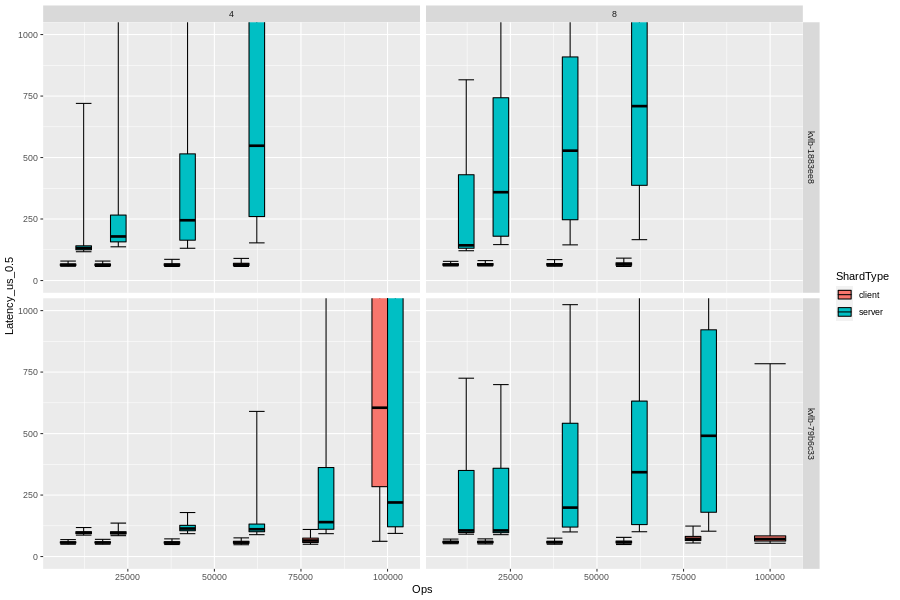

In [8]:
%%R -i plbdf -w 900 -h 600

#f <- function(x) {
#  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
#  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
#  r
#}

ggplot(plbdf, aes(x=Ops, fill=ShardType, group=interaction(ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  facet_grid(Commit~Concurrency) +
  coord_cartesian(ylim=c(0, 1000))